# Generalizing with OOP: The SMABaacktester Class

## Using the SMABacktester Class

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn-v0_8")

In [146]:
df = pd.read_csv("data/forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
df

,AUDEUR=X,EURUSD=X,USDGBP=X
Date,,,
2004-01-01,0.59780,1.258194,0.56016
2004-01-02,0.60314,1.258194,0.55751
2004-01-05,0.60467,1.268698,0.55334
2004-01-06,0.60350,1.272103,0.54906
2004-01-07,0.60728,1.264095,0.55012
...,...,...,...
2020-06-24,0.61349,1.131235,0.79841
2020-06-25,0.60938,1.125087,0.80561
2020-06-26,0.61373,1.122208,0.80480


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4295 entries, 2004-01-01 to 2020-06-30
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AUDEUR=X  4274 non-null   float64
 1   EURUSD=X  4275 non-null   float64
 2   USDGBP=X  4287 non-null   float64
dtypes: float64(3)
memory usage: 134.2 KB


## Building hte SMABacktester Class from scratch: Instantiation

In [147]:
class SMABacktester():
    ''' Class for the vectorized backtesting of SMA-based trading strategies
    '''
    def __init__(self, symbol, SMA_S, SMA_L, start, end):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        SMA_S: int
            moving window in bars (e.g. days) for shorter SMA
        SMA_L: int
            moving window in bars (e.g. days) for longer SMA
        start: str
            start date for data import
        end: str
            end date for data import
        '''
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.results = None
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Import the data from forex_pairs.csv (source can be changed).
        '''
        raw = pd.read_csv("data/forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        self.data = raw
        
    def prepare_data(self):
        '''Prepares the data for strategy backtesting (strategy-specific).
        '''
        data = self.data.copy()
        data["SMA_S"] = data["price"].rolling(self.SMA_S).mean()
        data["SMA_L"] = data["price"].rolling(self.SMA_L).mean()
        self.data = data
    
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and the prepared dataset.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the SMA-based trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        data["creturns"]  = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance
        outperf = perf - data["creturns"].iloc[-1] # outperformance
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first")
        else:
            title = "{} | SMA_S = {} | SMA_L = {}".format(self.symbol, self.SMA_S, self.SMA_L)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        combinations = list(product(range(*SMA_S_range), range(*SMA_L_range)))
        
        # test all combinations
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
            
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
        
        # create a df with many results
        many_results = pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        many_results["performance"] = results
        self.results_overview = many_results
        
        return opt, best_perf

In [148]:
tester = SMABacktester("EURUSD=X", 50, 200, "2004-01-01", "2020-06-30")

In [149]:
tester.data

,price,returns,SMA_S,SMA_L
Date,,,,
2004-01-01,1.258194,NaN,NaN,NaN
2004-01-02,1.258194,0.000000,NaN,NaN
2004-01-05,1.268698,0.008313,NaN,NaN
2004-01-06,1.272103,0.002681,NaN,NaN
2004-01-07,1.264095,-0.006315,NaN,NaN
...,...,...,...,...
2020-06-24,1.131235,0.002892,1.101794,1.103430
2020-06-25,1.125087,-0.005449,1.102486,1.103540
2020-06-26,1.122208,-0.002562,1.103213,1.103627


In [152]:
tester.results

,price,returns,SMA_S,SMA_L,position,strategy,creturns,cstrategy
Date,,,,,,,,
2004-10-07,1.229906,0.001475,1.221840,1.226081,-1,-0.001475,1.001476,0.998526
2004-10-08,1.241003,0.008982,1.222628,1.225995,-1,-0.008982,1.010511,0.989598
2004-10-11,1.238405,-0.002095,1.223352,1.225843,-1,0.002095,1.008396,0.991673
2004-10-12,1.232104,-0.005102,1.223888,1.225643,-1,0.005102,1.003265,0.996746
2004-10-13,1.234903,0.002270,1.224466,1.225497,-1,-0.002270,1.005545,0.994486
...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.101794,1.103430,-1,-0.002892,0.921130,1.271272
2020-06-25,1.125087,-0.005449,1.102486,1.103540,-1,0.005449,0.916125,1.278218
2020-06-26,1.122208,-0.002562,1.103213,1.103627,-1,0.002562,0.913781,1.281497


In [151]:
tester.test_strategy()

(1.2835, 0.367674)

In [143]:
tester.optimize_parameters((10,50,1),(100,252,1))

((46, 137), 2.526694)

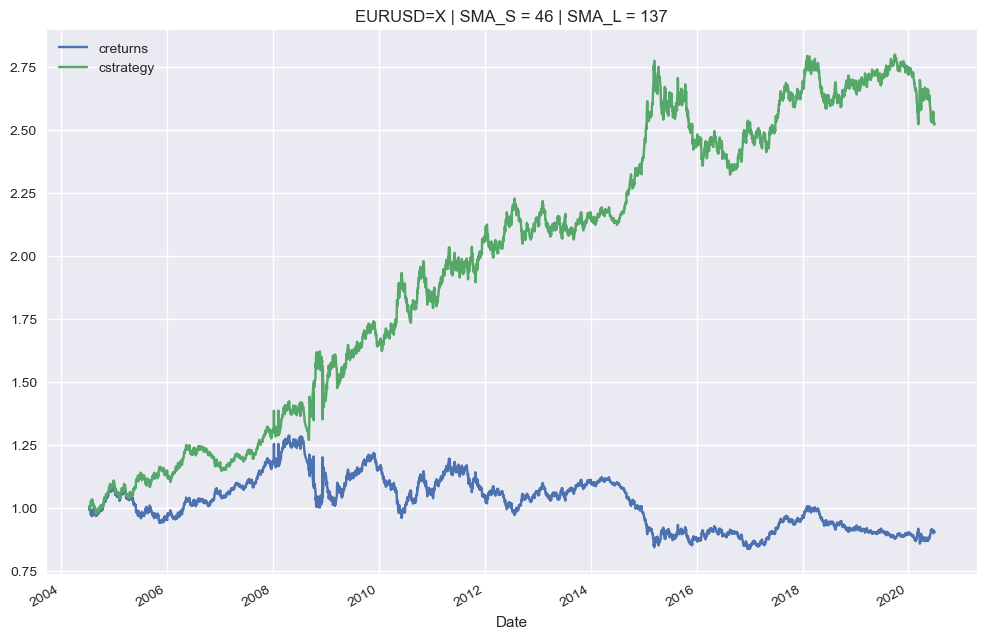

In [145]:
tester.plot_results()

## Method get_data()

In [16]:
raw = pd.read_csv("data/forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
raw

,AUDEUR=X,EURUSD=X,USDGBP=X
Date,,,
2004-01-01,0.59780,1.258194,0.56016
2004-01-02,0.60314,1.258194,0.55751
2004-01-05,0.60467,1.268698,0.55334
2004-01-06,0.60350,1.272103,0.54906
2004-01-07,0.60728,1.264095,0.55012
...,...,...,...
2020-06-24,0.61349,1.131235,0.79841
2020-06-25,0.60938,1.125087,0.80561
2020-06-26,0.61373,1.122208,0.80480


In [22]:
raw = raw["AUDEUR=X"].to_frame().dropna() # selecting an instrument

In [23]:
raw = raw.loc["2010-01-10":"2012-12-31"].copy()
raw

,AUDEUR=X
Date,
2010-01-11,0.64060
2010-01-12,0.63550
2010-01-13,0.63600
2010-01-14,0.64190
2010-01-15,0.64098
...,...
2012-12-25,0.78620
2012-12-26,0.78680
2012-12-27,0.78340


In [24]:
raw.rename(columns={"AUDEUR=X":"price"}, inplace=True) # clean up
raw

,price
Date,
2010-01-11,0.64060
2010-01-12,0.63550
2010-01-13,0.63600
2010-01-14,0.64190
2010-01-15,0.64098
...,...
2012-12-25,0.78620
2012-12-26,0.78680
2012-12-27,0.78340


In [25]:
raw["returns"] = np.log(raw / raw.shift(1)) # calculate log returns

In [28]:
raw["SMA_S"] = raw["price"].rolling(50).mean() # add short sma
raw["SMA_L"] = raw["price"].rolling(200).mean() # add long sma

In [29]:
raw

,price,returns,SMA_S,SMA_L
Date,,,,
2010-01-11,0.64060,NaN,NaN,NaN
2010-01-12,0.63550,-0.007993,NaN,NaN
2010-01-13,0.63600,0.000786,NaN,NaN
2010-01-14,0.64190,0.009234,NaN,NaN
2010-01-15,0.64098,-0.001434,NaN,NaN
...,...,...,...,...
2012-12-25,0.78620,-0.002921,0.803610,0.805435
2012-12-26,0.78680,0.000763,0.803618,0.805410
2012-12-27,0.78340,-0.004331,0.803462,0.805372


## Setting new SMA Parameters

In [44]:
tester.SMA_S

30

In [42]:
tester.SMA_L

250

In [41]:
tester.SMA_L = 250

In [43]:
tester.SMA_S = 30

In [45]:
tester.data.isna().sum()

price        0
returns      1
SMA_S       49
SMA_L      199
dtype: int64

## TEsting a Strategy

## Plottting the results

## Strategy Optimization